In [1]:
import numpy as np
from utils_data_loading import*
from utils_predictions_manipulation import*
from utils_nans_manipulation import*
from cross_validation import*

import matplotlib.pyplot as plt

### Loading training data

In [2]:
traindata,_ = load_data('Data/train.csv')

In [3]:
X_total, Y_total = structure_data(traindata)

In [4]:
# Replacing undefined data with NaNs
X_nans = replace_bad_data_with_nans(X_total, -999)

# Splitting the dataset based on presence of NaNs
X_no_nans, Y_no_nans = delete_nan_points(X_nans, Y_total)
X_with_nans, Y_with_nans = store_nan_points(X_nans, Y_total)

# Replacing NaNs with median
X_cleaned = replace_nans_with_median(X_with_nans, threshold=0.3)
Y_cleaned = Y_with_nans  # As we do not delete any data point, Y is the same for the cleaned data

In [5]:
print(X_total.shape, X_cleaned.shape, X_no_nans.shape)

(250000, 31) (181886, 21) (68114, 31)


### Observing distributions

In [47]:
import statistics

def standardize_by_distribution(data, st_type):
    '''Allows for standardization by different distributions'''
    
    out = data[[not np.isnan(i) for i in data]]

    # No standardization
    if st_type==0:
        return data
    
    # Gaussian standardization
    if st_type==1:
        data = data - out.mean()
        data = data/out.std()
        return data
    
    # Poisson standardization (mean == std)
    if st_type==2:
        data = data/out.std()
        return data
    
    # Mean stadardization (mean = 2x std)
    if st_type==3:
        data = data/out.mean()
        return data
    
    # Skewed standardization
    if st_type==4:
        data = data - statistics.mode(out)
        data = data/out.std()
        return data
    
    # Max standardization
    if st_type==5:
        data = data/out.max()
        return data
    

In [48]:
def select_standardization(data):
    """Returns the type of standardization to apply to each feature (data)"""
    
    out = data[[not np.isnan(i) for i in data]]
    
    if len(np.unique(out))<10:          #No standardization if categorical
        st_type = 0
        
    elif ((out.max()-out.min())<2) & (out.max()<10): #No standardization if small span
        st_type = 0
        
    elif out.min()>=0:
        if out.mean()/out.std()>=2.8:   #Mode standardization for spread out
            st_type = 4
        elif out.mean()/out.std()>=1.5: #Mean standardization
            st_type = 3
        elif out.mean()/out.std()>=0.5: #Std Standardization
            st_type = 2
        else:                           #Max standardixation
            st_type = 5
            
    elif abs(out.min())==out.max():     #Max standardization
        st_type = 5
        
    else:                               #Gaussian standardization
        st_type = 1
    
    return st_type

In [50]:
def standardize_data(X_array):
    '''Returns the standardized data array as internally defined in st_types'''
    
    X_out = X_array.copy()
    for i in range(X_array.shape[1]):
        data = X_array[:,i]
        st_type = select_standardization(data)
        X_out[:,i] = standardize_by_distribution(data, st_type)
        
    return X_out

In [51]:
X_st = standardize_data(X_nans)

0 
 Mean: 1.0 Stdv: 0.0


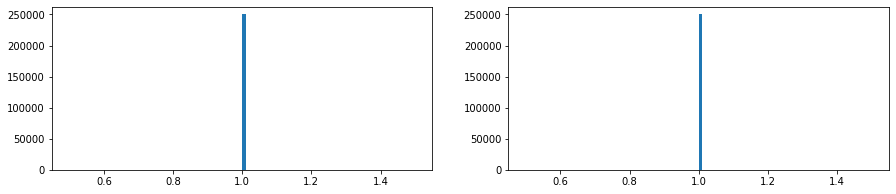

1 
 Mean: 121.85852835958957 Stdv: 57.29802144982738


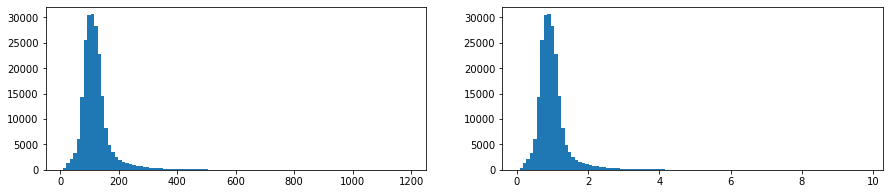

2 
 Mean: 49.239819276 Stdv: 35.34481492202995


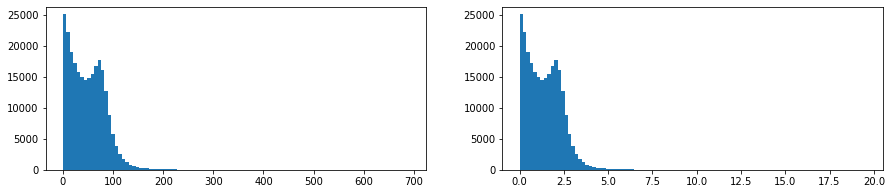

3 
 Mean: 81.181981612 Stdv: 40.8286088749526


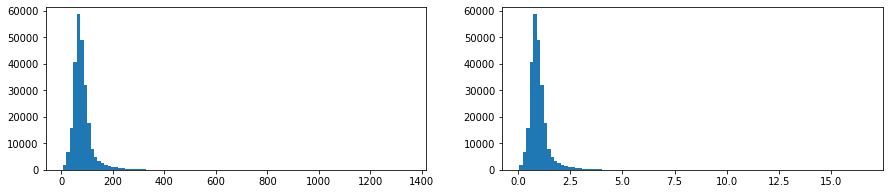

4 
 Mean: 57.895961656 Stdv: 63.65555430684573


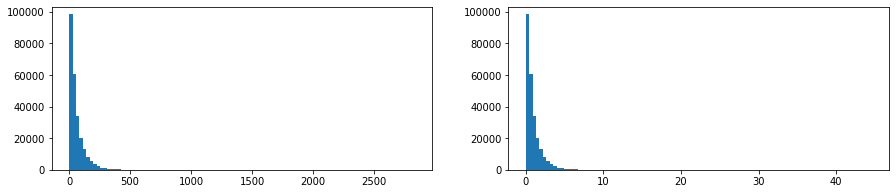

5 
 Mean: 2.4037350261224373 Stdv: 1.7422143071664111


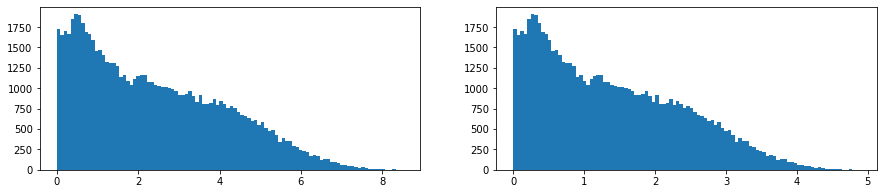

6 
 Mean: 371.78336044828586 Stdv: 397.69658433794086


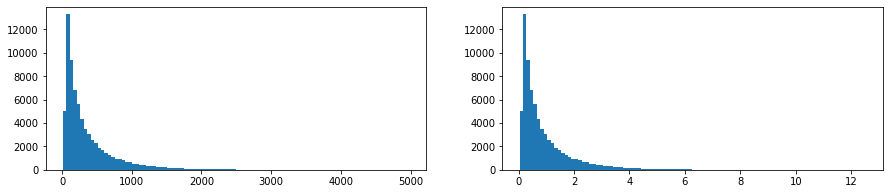

7 
 Mean: -0.8216881711536604 Stdv: 3.5843373103759


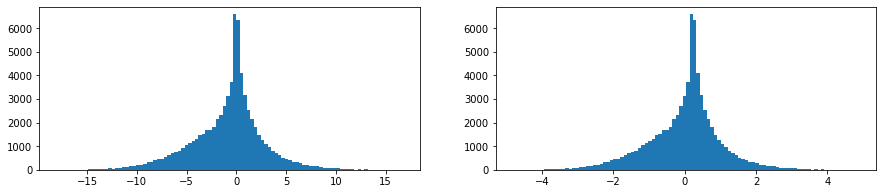

8 
 Mean: 2.3730998440000004 Stdv: 0.7829095528215093


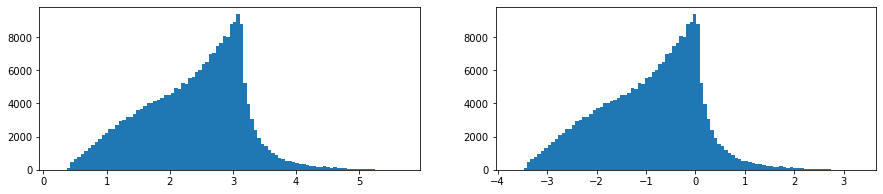

9 
 Mean: 18.91733244400001 Stdv: 22.273449204924436


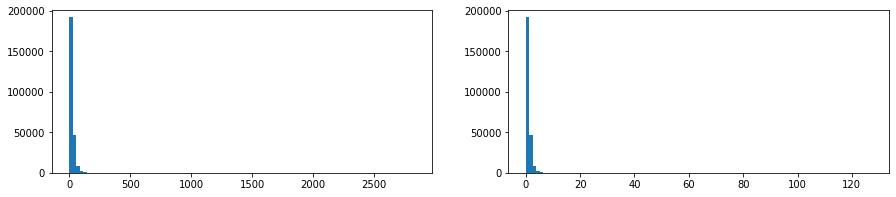

10 
 Mean: 158.432217048 Stdv: 115.70588372102608


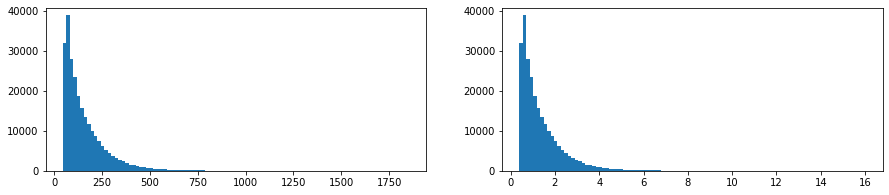

11 
 Mean: 1.4376094319999997 Stdv: 0.8447412551738178


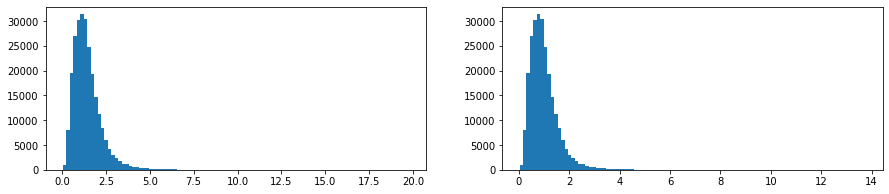

12 
 Mean: -0.12830470800000002 Stdv: 1.1935824486029587


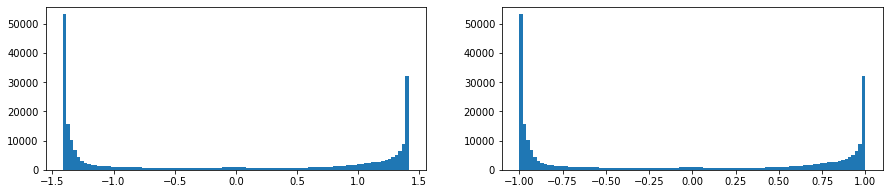

13 
 Mean: 0.45828980053209817 Stdv: 0.3986786062151179


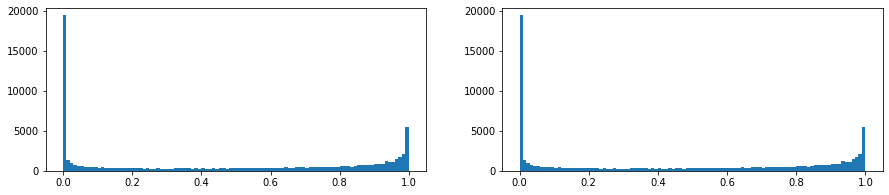

14 
 Mean: 38.70741912799999 Stdv: 22.41203584249596


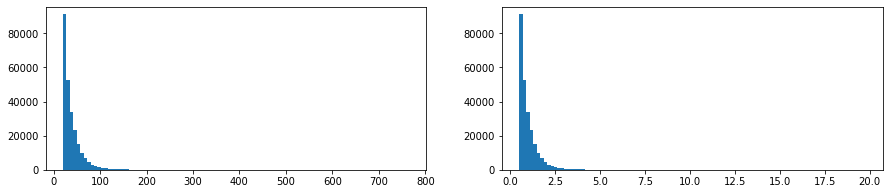

15 
 Mean: -0.010973048000000001 Stdv: 1.2140762178683797


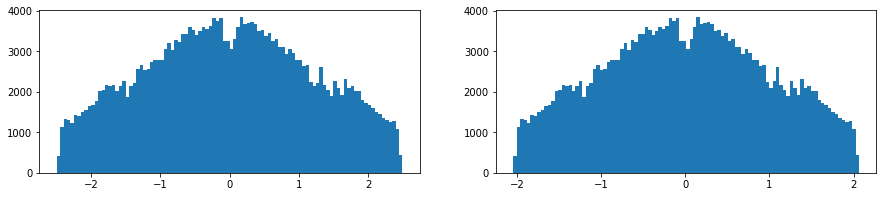

16 
 Mean: -0.008171072000000005 Stdv: 1.8167594108451375


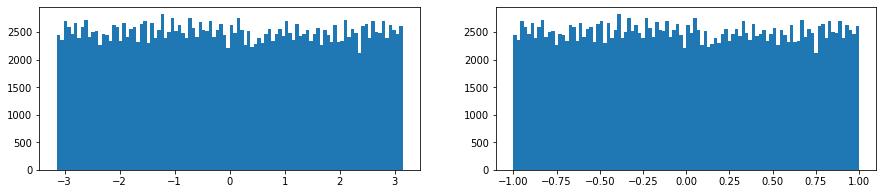

17 
 Mean: 46.66020724800001 Stdv: 22.06487827506729


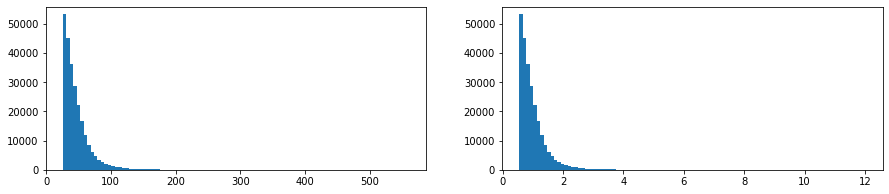

18 
 Mean: -0.019507467999999997 Stdv: 1.2649796185204838


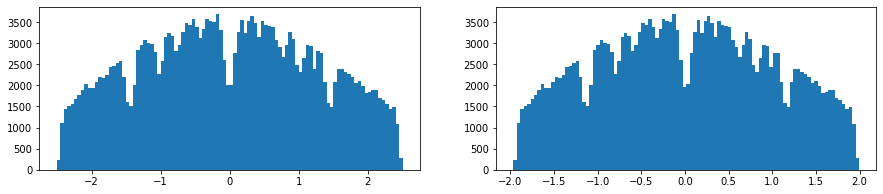

19 
 Mean: 0.043542963999999997 Stdv: 1.8166076295893112


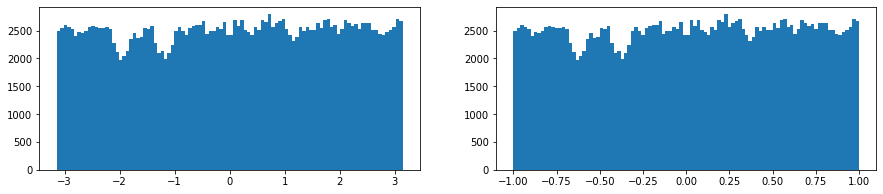

20 
 Mean: 41.71723452400001 Stdv: 32.8946274025167


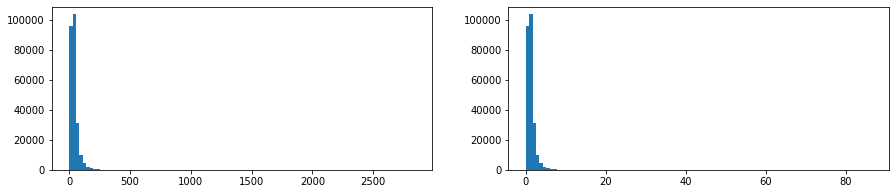

21 
 Mean: -0.010119191999999999 Stdv: 1.8122190775381621


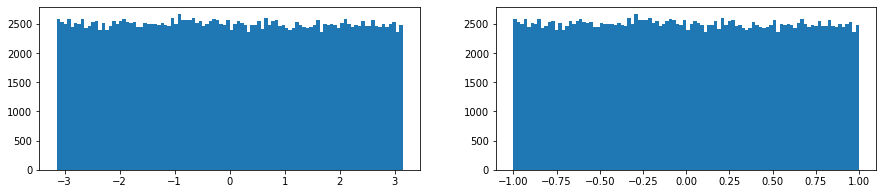

22 
 Mean: 209.79717763200006 Stdv: 126.49925271717557


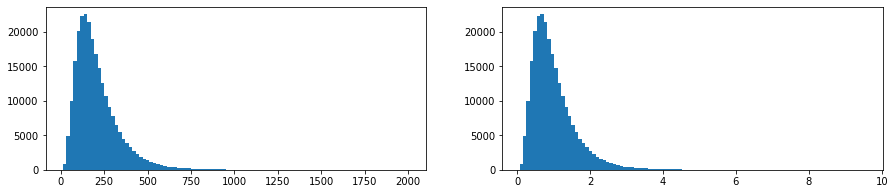

23 
 Mean: 0.979176 Stdv: 0.9774243505376773


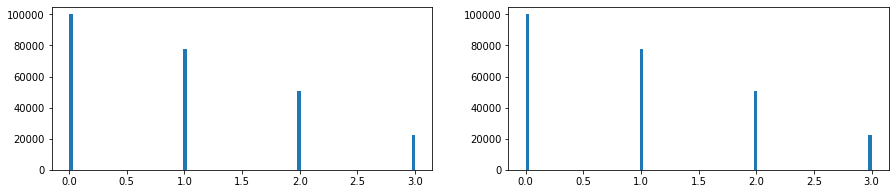

24 
 Mean: 84.82210453270434 Stdv: 60.66207396692587


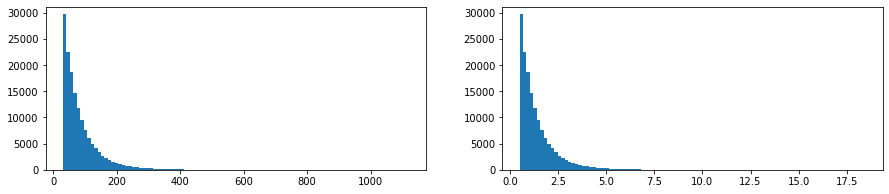

25 
 Mean: -0.0032745874059712044 Stdv: 1.784540015878535


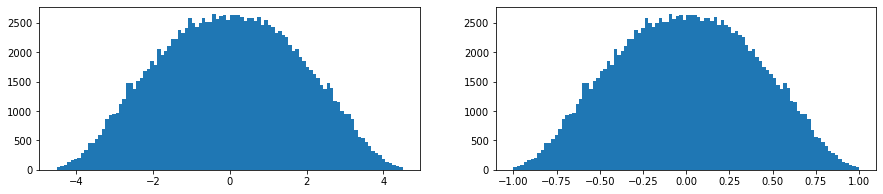

26 
 Mean: -0.012392825494546494 Stdv: 1.81337942573136


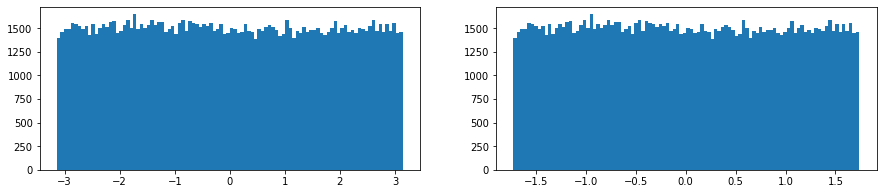

27 
 Mean: 57.67947442206691 Stdv: 31.985561217034174


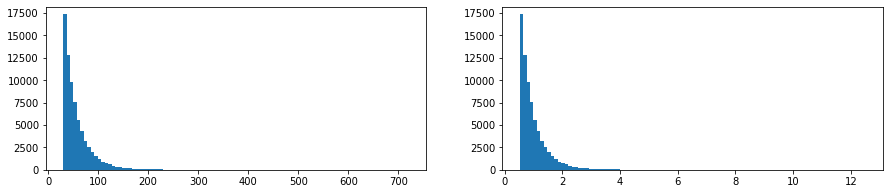

28 
 Mean: -0.01184526418813669 Stdv: 2.031728596982156


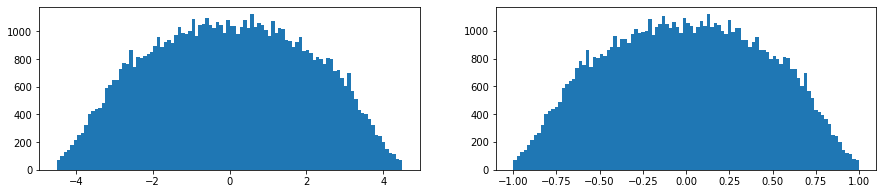

29 
 Mean: -0.001582289125070648 Stdv: 1.8169372027338675


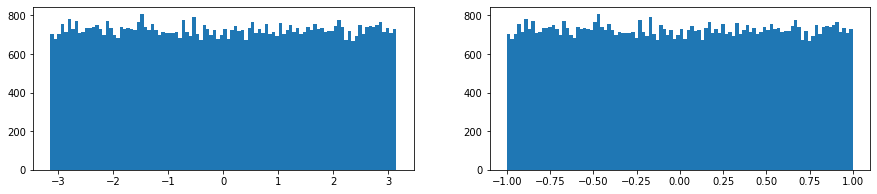

30 
 Mean: 73.06459138400002 Stdv: 98.01546597673655


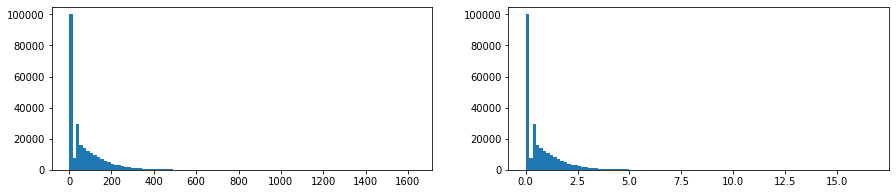

In [52]:
for i in range(X_nans.shape[1]):
    data = X_nans[:,i]
    out = data[[not np.isnan(i) for i in data]]
    print(i,"\n Mean:", out.mean(), "Stdv:", out.std())
    
    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.hist(data,bins=100)
    
    plt.subplot(1,2,2)
    plt.hist(X_st[:,i],bins=100)
    plt.show()
    
 

## Understanding eucledian distance

In [167]:
X_stn = replace_nans_with_median(X_st, threshold=0.3)
X_stn.shape

(250000, 21)

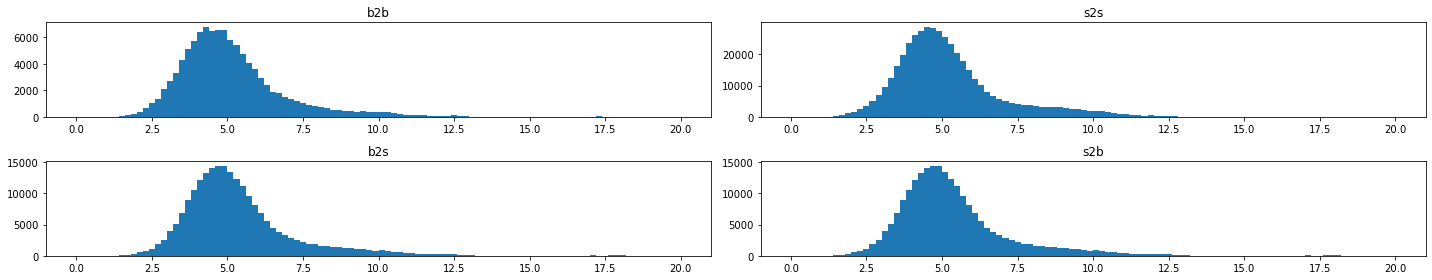

In [177]:
b2b = []
s2s = []
b2s = []
s2b = []

random_indices = np.random.choice(X_stn.shape[0],1000,replace=False)

for i1 in random_indices:
    for i2 in random_indices:
        if not i1==i2: 
            if Y_total[i1] == Y_total[i2]:
                if Y_total[i1] == 1:
                    b2b.append(np.linalg.norm(X_stn[i1,:] - X_stn[i2,:]))
                else:
                    s2s.append(np.linalg.norm(X_stn[i1,:] - X_stn[i2,:]))
            else:
                if Y_total[i1] == 1:
                    b2s.append(np.linalg.norm(X_stn[i1,:] - X_stn[i2,:]))
                else:
                    s2b.append(np.linalg.norm(X_stn[i1,:] - X_stn[i2,:]))

bins = 100
rang = [0,20]
plt.figure(figsize=[20,4])
plt.subplot(2,2,1)
plt.hist(b2b, bins=bins, range=rang)
plt.title("b2b")

plt.subplot(2,2,2)
plt.hist(s2s, bins=bins, range=rang)
plt.title("s2s")

plt.subplot(2,2,3)
plt.hist(b2s, bins=bins, range=rang)
plt.title("b2s")

plt.subplot(2,2,4)
plt.hist(s2b, bins=bins, range=rang)
plt.title("s2b")

plt.tight_layout()
plt.show()

In [178]:
print(np.mean(b2b),
      np.mean(s2s),
      np.mean(b2s),
      np.mean(s2b))

5.193027877450396 5.258451357052099 5.366541755423817 5.3665417554238175


## Combination of divisions

In [306]:
# Feature, separation value
thresh = [[23, 0.5],
          [23, 1.5],
          [23, 2.5],
          [12, 0],
          [13, 0.5]]

In [307]:
def split_data_set(X_total, thresh):
    '''Generates sets of from data_set (X_array) split according to all combinations of split thresholds (thresh)'''
    import itertools
    
    #Generates all combinations of thresholds
    combinations = []
    for i in range(len(thresh)):
        out = list(itertools.combinations(thresh, i+1))
        combinations.append([i for i in out])
    flat_list = [item for sublist in combinations for item in sublist]
    
    data_sets = []
    for sublist in flat_list:
        #Iterates over sublist and creates split array
        in_arrays = [X_total]
        out_arrays = [] # Temporary variable used for holding splits
        
        for split in sublist:
            #Applies all splits in sublist
            for array in in_arrays:
                out_arrays.append(array[array[:,split[0]]>=split[1]])
                out_arrays.append(array[array[:,split[0]]<split[1]])
            in_arrays = out_arrays.copy()
            out_arrays = []

        #Verifies if points are missing or duplicated 
        if not sum([arr.shape[0] for arr in in_arrays]) == X_total.shape[0]:
            print("Error in splitting arrays")

        #Stores each dataset (for each sublist of splits)
        data_sets.append(in_arrays)

    # Removes empty split sets 
    sets_clean = []
    for dset in data_sets:
        sets_clean.append([split for split in dset if split.shape[0]>0])
        
    return sets_clean, flat_list

In [312]:
data_sets, thresholds = split_data_set(X_total, thresh)

In [313]:
print(len(data_sets), len(thresholds))
thresholds

31 31


[([23, 0.5],),
 ([23, 1.5],),
 ([23, 2.5],),
 ([12, 0],),
 ([13, 0.5],),
 ([23, 0.5], [23, 1.5]),
 ([23, 0.5], [23, 2.5]),
 ([23, 0.5], [12, 0]),
 ([23, 0.5], [13, 0.5]),
 ([23, 1.5], [23, 2.5]),
 ([23, 1.5], [12, 0]),
 ([23, 1.5], [13, 0.5]),
 ([23, 2.5], [12, 0]),
 ([23, 2.5], [13, 0.5]),
 ([12, 0], [13, 0.5]),
 ([23, 0.5], [23, 1.5], [23, 2.5]),
 ([23, 0.5], [23, 1.5], [12, 0]),
 ([23, 0.5], [23, 1.5], [13, 0.5]),
 ([23, 0.5], [23, 2.5], [12, 0]),
 ([23, 0.5], [23, 2.5], [13, 0.5]),
 ([23, 0.5], [12, 0], [13, 0.5]),
 ([23, 1.5], [23, 2.5], [12, 0]),
 ([23, 1.5], [23, 2.5], [13, 0.5]),
 ([23, 1.5], [12, 0], [13, 0.5]),
 ([23, 2.5], [12, 0], [13, 0.5]),
 ([23, 0.5], [23, 1.5], [23, 2.5], [12, 0]),
 ([23, 0.5], [23, 1.5], [23, 2.5], [13, 0.5]),
 ([23, 0.5], [23, 1.5], [12, 0], [13, 0.5]),
 ([23, 0.5], [23, 2.5], [12, 0], [13, 0.5]),
 ([23, 1.5], [23, 2.5], [12, 0], [13, 0.5]),
 ([23, 0.5], [23, 1.5], [23, 2.5], [12, 0], [13, 0.5])]